# LSTM with social

In [1]:
import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import time
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train_path = "processed_train.npz"
train_data = np.load(train_path)
test_path = "processed_val_in.npz"
test_data = np.load(test_path)

In [3]:
class LSTMEncoder(nn.Module):
    def __init__(self,
                 in_dim,
                 hidden_dim,
                 embed_dim,
                ):
        
        super(LSTMEncoder, self).__init__()
        
        self.linear = nn.Linear(in_dim, hidden_dim)
        self.lstm = nn.LSTMCell(hidden_dim, embed_dim)
        
    def forward(self, x, embedded):
        lx = F.relu(self.linear(x))
        embedded = self.lstm(lx, embedded)
        return embedded

class LSTMDecoder(nn.Module):
    def __init__(self, 
                 out_dim,
                 hidden_dim,
                 embed_dim,
                ):
        
        super(LSTMDecoder, self).__init__()
        
        self.linear = nn.Linear(out_dim, hidden_dim)
        self.lstm = nn.LSTMCell(hidden_dim, embed_dim)
        
    def forward(self, x, hidden):
        lx = F.relu(self.linear(x))
        hidden = self.lstm(lx, hidden)
        return hidden

class EmbedToOutput(nn.Module):
    def __init__(self,
                embed_dim,
                out_dim
            ):
    
        super(EmbedToOutput, self).__init__()
        self.linear = nn.Linear(embed_dim, out_dim)
    
    def forward(self, hidden):
        out = self.linear(hidden[0])
        return out

In [4]:
batch_size = 512
in_dim = 5
out_dim = 2
hidden_dim = 8
embed_dim = 16
learning_rate = 0.01
decay_rate = 0.99
num_epoch = 1000
roll_outs = [1, 3, 10, 30]

In [5]:
# RNN, LSTM, 1dCNN, Transformer
encoder = LSTMEncoder(in_dim = in_dim,
               hidden_dim = hidden_dim,
               embed_dim = embed_dim).to(device) # move model to gpu 

decoder = LSTMDecoder(out_dim = out_dim,
               hidden_dim = hidden_dim,
               embed_dim = embed_dim).to(device) # move model to gpu 

to_output = EmbedToOutput(embed_dim = embed_dim,
               out_dim = out_dim).to(device)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
to_output_optimizer = torch.optim.Adam(to_output.parameters(), lr=learning_rate)
encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=1, gamma=decay_rate)
decoder_scheduler = torch.optim.lr_scheduler.StepLR(decoder_optimizer, step_size=1, gamma=decay_rate)
to_output_scheduler = torch.optim.lr_scheduler.StepLR(to_output_optimizer, step_size=1, gamma=decay_rate)
loss_fun = nn.MSELoss()

In [6]:
def train_epoch(encoder, decoder, to_output, encoder_optimizer, decoder_optimizer, to_output_optimizer, loss_function, roll_out):
    train_mse = []
    shuffler = np.random.permutation(np.arange(390 * batch_size))
    for i in range(390):
        batch_ids = shuffler[i * batch_size:(i+1) * batch_size]
        inp = torch.from_numpy(train_data["X"][batch_ids]).float().to(device).reshape(batch_size, 19, -1)
        tgt = torch.from_numpy(train_data["y"][batch_ids]).float().to(device).reshape(batch_size, 30, 2)
        tgt = tgt[:, :roll_out, :]

        embedded_vec = (
            torch.zeros(batch_size, embed_dim).to(device),
            torch.zeros(batch_size, embed_dim).to(device),
        )
        loss1 = 0
        for step in range(19):
            embedded_vec = encoder(inp[:, step, :], embedded_vec)
            known_seq_out = to_output(embedded_vec)
            if step != 18:
                loss1 += loss_function(known_seq_out, inp[:, step + 1, :2])
        loss2 = 0
        pred = inp[:, -1, :2]
        for step in range(roll_out):
            embedded_vec = decoder(pred, embedded_vec)
            pred = to_output(embedded_vec)
            loss2 += loss_function(pred, tgt[:, step, :])
        
        loss = loss1 / 18 + loss2 / roll_out
        
        train_mse.append(loss.item()) 
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        to_output_optimizer.zero_grad()
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        to_output_optimizer.step()
    train_mse = round(np.sqrt(np.mean(train_mse)),5)
    return train_mse

def eval_epoch(encoder, decoder, to_output, loss_function, roll_out):
    valid_mse = []
    preds = []
    trues = []
    with torch.no_grad():
        for i in range(390, 402):
            inp = torch.from_numpy(train_data["X"][i * batch_size:(i+1) * batch_size]).float().to(device).reshape(batch_size, 19, -1)
            tgt = torch.from_numpy(train_data["y"][i * batch_size:(i+1) * batch_size]).float().to(device).reshape(batch_size, 30, 2)
            tgt = tgt[:, :roll_out, :]
            
            embedded_vec = (
                torch.zeros(batch_size, embed_dim).to(device),
                torch.zeros(batch_size, embed_dim).to(device),
            )
            loss1 = 0
            for step in range(19):
                embedded_vec = encoder(inp[:, step, :], embedded_vec)
                known_seq_out = to_output(embedded_vec)
                if step != 18:
                    loss1 += loss_function(known_seq_out, inp[:, step + 1, :2])
            
            loss2 = 0
            pred = inp[:, step, :2]
            for step in range(roll_out):
                embedded_vec = decoder(pred, embedded_vec)
                pred = to_output(embedded_vec)
                loss2 += loss_function(pred, tgt[:, step, :])
            loss = loss1 / 18 + loss2 / roll_out
            valid_mse.append(loss.item())
            
        valid_mse = round(np.sqrt(np.mean(valid_mse)), 5)
    return valid_mse

In [7]:
train_rmse = []
valid_rmse = []
min_rmse = 10e8
worse_count = 0

roll_out_id = 0

for i in range(num_epoch):
    start = time.time()

    # model.train() # if you use dropout or batchnorm. 
    train_rmse.append(train_epoch(encoder, decoder, to_output, encoder_optimizer, decoder_optimizer, to_output_optimizer, loss_fun, roll_outs[roll_out_id]))

    # model.eval()
    val_rmse = eval_epoch(encoder, decoder, to_output, loss_fun, roll_outs[roll_out_id])
    valid_rmse.append(val_rmse)

    # save the best model
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1]
        best_model = (encoder, decoder, to_output)
        worse_count = 0
        # torch.save([best_model, i, get_lr(optimizer)], name + ".pth")
    else:
        worse_count += 1
    
    if worse_count > 10:
        roll_out_id += 1
        worse_count = 0
        min_rmse = 10e8
        encoder, decoder, to_output = best_model
    
    if roll_out_id >= len(roll_outs):
        break

    end = time.time()
    
    # Early Stopping
    # if (len(train_rmse) > 100 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
    #        break

    # Learning Rate Decay        
    encoder_scheduler.step()
    decoder_scheduler.step()
    to_output_scheduler.step()
    
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f} | Current Roll Out: {}".format(i + 1, (end-start) / 60, train_rmse[-1], valid_rmse[-1], roll_outs[roll_out_id]))

Epoch 1 | T: 2.16 | Train RMSE: 5.68806 | Valid RMSE: 1.70882 | Current Roll Out: 1
Epoch 2 | T: 2.16 | Train RMSE: 1.49822 | Valid RMSE: 1.04265 | Current Roll Out: 1
Epoch 3 | T: 2.16 | Train RMSE: 1.08846 | Valid RMSE: 0.80817 | Current Roll Out: 1
Epoch 4 | T: 2.16 | Train RMSE: 0.89703 | Valid RMSE: 0.71314 | Current Roll Out: 1
Epoch 5 | T: 2.16 | Train RMSE: 0.77713 | Valid RMSE: 0.59966 | Current Roll Out: 1
Epoch 6 | T: 2.15 | Train RMSE: 0.68670 | Valid RMSE: 0.54890 | Current Roll Out: 1
Epoch 7 | T: 2.15 | Train RMSE: 0.62741 | Valid RMSE: 0.50718 | Current Roll Out: 1
Epoch 8 | T: 2.16 | Train RMSE: 0.58254 | Valid RMSE: 0.48581 | Current Roll Out: 1
Epoch 9 | T: 2.17 | Train RMSE: 0.55390 | Valid RMSE: 0.47908 | Current Roll Out: 1
Epoch 10 | T: 2.15 | Train RMSE: 0.51815 | Valid RMSE: 0.44212 | Current Roll Out: 1
Epoch 11 | T: 2.16 | Train RMSE: 0.49345 | Valid RMSE: 0.43782 | Current Roll Out: 1
Epoch 12 | T: 2.16 | Train RMSE: 0.47874 | Valid RMSE: 0.43539 | Current R

Epoch 98 | T: 2.11 | Train RMSE: 0.48340 | Valid RMSE: 0.48199 | Current Roll Out: 3
Epoch 99 | T: 2.12 | Train RMSE: 0.48265 | Valid RMSE: 0.48205 | Current Roll Out: 3
Epoch 100 | T: 2.11 | Train RMSE: 0.48326 | Valid RMSE: 0.48838 | Current Roll Out: 3
Epoch 101 | T: 2.12 | Train RMSE: 0.48253 | Valid RMSE: 0.48048 | Current Roll Out: 3
Epoch 102 | T: 2.15 | Train RMSE: 0.48445 | Valid RMSE: 0.49323 | Current Roll Out: 3
Epoch 103 | T: 2.21 | Train RMSE: 0.48244 | Valid RMSE: 0.48111 | Current Roll Out: 3
Epoch 104 | T: 2.19 | Train RMSE: 0.48219 | Valid RMSE: 0.48163 | Current Roll Out: 3
Epoch 105 | T: 2.20 | Train RMSE: 0.48203 | Valid RMSE: 0.48536 | Current Roll Out: 3
Epoch 106 | T: 2.19 | Train RMSE: 0.48274 | Valid RMSE: 0.48127 | Current Roll Out: 3
Epoch 107 | T: 2.20 | Train RMSE: 0.48251 | Valid RMSE: 0.48251 | Current Roll Out: 3
Epoch 108 | T: 2.19 | Train RMSE: 0.48191 | Valid RMSE: 0.48248 | Current Roll Out: 3
Epoch 109 | T: 2.19 | Train RMSE: 0.48208 | Valid RMSE: 

Epoch 193 | T: 2.17 | Train RMSE: 0.78328 | Valid RMSE: 0.79481 | Current Roll Out: 10
Epoch 194 | T: 2.16 | Train RMSE: 0.78246 | Valid RMSE: 0.80892 | Current Roll Out: 10
Epoch 195 | T: 2.17 | Train RMSE: 0.78391 | Valid RMSE: 0.79874 | Current Roll Out: 10
Epoch 196 | T: 2.16 | Train RMSE: 0.78259 | Valid RMSE: 0.79825 | Current Roll Out: 10
Epoch 197 | T: 2.17 | Train RMSE: 0.78172 | Valid RMSE: 0.79311 | Current Roll Out: 10
Epoch 198 | T: 2.16 | Train RMSE: 0.78161 | Valid RMSE: 0.79881 | Current Roll Out: 10
Epoch 199 | T: 2.17 | Train RMSE: 0.78365 | Valid RMSE: 0.82576 | Current Roll Out: 10
Epoch 200 | T: 2.16 | Train RMSE: 0.78877 | Valid RMSE: 0.80742 | Current Roll Out: 10
Epoch 201 | T: 2.17 | Train RMSE: 0.78106 | Valid RMSE: 0.80331 | Current Roll Out: 10
Epoch 202 | T: 2.16 | Train RMSE: 0.78126 | Valid RMSE: 0.79875 | Current Roll Out: 10
Epoch 203 | T: 2.18 | Train RMSE: 0.78127 | Valid RMSE: 0.79645 | Current Roll Out: 10
Epoch 204 | T: 2.18 | Train RMSE: 0.78160 |

In [9]:
def inverse_transform_path(path, shift, rotation_matrix):
    if path.ndim == 2:
        return (np.linalg.inv(rotation_matrix) @ path.T).T + shift
    elif path.ndim == 3:
        path_normalize = np.zeros(path.shape)
        for i in range(path.shape[0]):
            path_normalize[i] = (np.linalg.inv(rotation_matrix) @ path[i].T).T + shift
        return path_normalize
    else:
        raise Exception("Invalid dimension")
        
encoder, decoder, to_output = best_model
test_preds = []
for i in tqdm(range(len(test_data["X"]))):
    inp = torch.from_numpy(test_data["X"][i]).float().to(device).unsqueeze(0)
    
    embedded_vec = (
        torch.zeros(1, embed_dim).to(device),
        torch.zeros(1, embed_dim).to(device),
    )
    for step in range(19):
        embedded_vec = encoder(inp[:, step, :], embedded_vec)

    preds = []
    pred = inp[:, step, :2]
    for step in range(30):
        embedded_vec = decoder(pred, embedded_vec)
        pred = to_output(embedded_vec)
        preds.append(pred.cpu().data.numpy())

    preds = np.array(preds).reshape(30, 2)
    
    # De-Normalization !
    preds = inverse_transform_path(preds, test_data["shifts"][i], test_data["rotation_matrices"][i])
    test_preds.append(preds)

100%|██████████████████████████████████████████████████████████████████████████████| 3200/3200 [01:15<00:00, 42.43it/s]


In [10]:
# Convert to int
sample_sub = pd.read_csv('sample_submission.csv')
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1).astype(int)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df.to_csv('test_submission.csv', index=None)

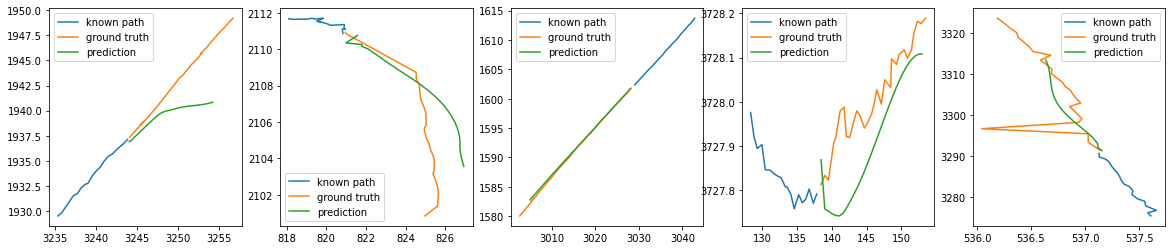

In [24]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    inp = torch.from_numpy(train_data["X"][i]).float().to(device).unsqueeze(0)
    
    embedded_vec = (
        torch.zeros(1, embed_dim).to(device),
        torch.zeros(1, embed_dim).to(device),
    )
    for step in range(19):
        embedded_vec = encoder(inp[:, step, :], embedded_vec)

    preds = []
    pred = inp[:, step, :2]
    for step in range(30):
        embedded_vec = decoder(pred, embedded_vec)
        pred = to_output(embedded_vec)
        preds.append(pred.cpu().data.numpy())

    preds = np.array(preds).reshape(30, 2)
    preds = inverse_transform_path(preds, train_data["shifts"][i], train_data["rotation_matrices"][i])
    known = inverse_transform_path(train_data["X"][i, :, :2], train_data["shifts"][i], train_data["rotation_matrices"][i])
    gt = inverse_transform_path(train_data["y"][i], train_data["shifts"][i], train_data["rotation_matrices"][i])
    ax[i].plot(known.T[0], known.T[1], label="known path")
    ax[i].plot(gt.T[0], gt.T[1], label="ground truth")
    ax[i].plot(preds.T[0], preds.T[1], label="prediction")
    ax[i].legend()